## Classico - Job categorization with conv net embeddings + classification layers

In this notebook there is a complete workflow for training and evaluating our multi language model for job categorization. 
The main phases of the work are:
- Imports and loading training dataset
- Building the model and training it
- Evaluation

### Imports

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import warnings
import os
import sys
import matplotlib.pyplot as plt
import pathlib
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 500
tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
root_path = str(pathlib.Path(os.path.dirname(os.path.realpath("__file__"))).resolve())
data_path = os.path.join(root_path, "data")

In [4]:
TRAINING_FILE_NAME = "sample_training.csv"
EVAL_FILE_NAME = "sample_evaluation.csv"
LANGS = ["de", "pt", "en", "it"]

### Loading training dataset

In [5]:
df = pd.read_csv(os.path.join(data_path, TRAINING_FILE_NAME))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6000 non-null   object
 1   category  6000 non-null   object
 2   language  6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


In [7]:
df.sample(5)

,title,category,language
2655,gerente de gestao ativos multifamiliar,Finance,pt
5859,clinical psychologist band ftc,Medical,en
2158,banker float bourne area,Finance,en
5739,head of clinical theatre services,Medical,en
2423,mortgage underwriter manager,Finance,en


In [8]:
# drop null values
df = df.drop(df[df["title"].isna()].index)

In [9]:
len(df)

6000

In [10]:
df["language"].value_counts()

en    3355
it    1060
pt     858
de     727
Name: language, dtype: int64

In [11]:
df["category"].value_counts()

Accounting    1000
Education     1000
Finance       1000
Food          1000
IT            1000
Medical       1000
Name: category, dtype: int64

In [12]:
N_CATEGORIES = len(df.category.unique())

## Modeling

In order to create the embeddings of the titles, we use an encoder that has high speed and good accuracy on capturing the context of a sentence/title: [Multilingual Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3), downloadable from tensorflow hub.
The steps that we followed for creating and training our model are:

 1. Split data in train/test to evaluate performances and fine-tune the hyperparameters
 2. Create the model architecture, that receives the titles strings as input, and produces the predicted category:
	 - The structure is composed by:
         - input layer for reading titles strings
         - pre-processing layer for cleaning the input (patterns to remove, html, normalization)
         - dense layers + dropout in order to avoid overfitting
         - softmax layer for the output
	 - Optimizer: *adam*
	 - Loss: SparseCategorical Cross Entropy
3. Training
4. Evaluation of performances on test data

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [14]:
label_col = "category"

In [15]:
le = preprocessing.LabelEncoder()
le.fit(df[label_col].values)
df["label"] = le.transform(df[label_col])

In [16]:
df.sample(5)

,title,category,language,label
3932,oficina supervisora de catering,Food,pt,3
4524,betreiber von swing shift,IT,de,4
1870,special education assistant murrieta mesa high school open promotional,Education,en,1
1413,academic skills advisor,Education,en,1
1127,auxiliar de instrucao ver requisito,Education,pt,1


In [17]:
batch_size = 100
title_column = "title"

### Load model from TF Hub

In [18]:
encoder_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
sentence_encoder = hub.load(encoder_url)

Metal device set to: Apple M1


2022-05-02 14:18:17.859545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 14:18:17.859646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-02 14:18:19.953895: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 14:18:19.954442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [19]:
X = df[title_column].values
y = df["label"].values

### Split dataset in train and test

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42, shuffle=True
)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5400,), (600,), (5400,), (600,))

In [22]:
class_names = le.classes_
labels_size = len(le.classes_)
batch_size = 64

### Load custom stopwords and patterns to be removed from titles, used in the pre-processing function defined below

In [23]:
with open(os.path.join(data_path, "custom_stopwords.txt")) as f:
    custom_stopwords = [line.rstrip() for line in f.readlines()]

with open(os.path.join(data_path, "to_replace.txt")) as f:
    patterns_to_remove = [line.rstrip() for line in f.readlines()]

In [24]:
@tf.keras.utils.register_keras_serializable()
def preprocess_text(input_data):
    cleaned = tf.strings.lower(input_data)
    cleaned = tf.strings.regex_replace(cleaned, r"\xa0", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\&amp", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"<.*?>", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\(.+?\)", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(patterns_to_remove) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(custom_stopwords) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned, r"[!\"#$%&\'()*+,-.–\/:;<=>?@[\\\]\^_`{|}~]", " ", replace_global=True
    )
    cleaned = tf.strings.regex_replace(cleaned, r"\b\d+\b", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\s+", " ", replace_global=True)
    return tf.strings.strip(cleaned)

### Build the model architecture

Here we are selecting sample parameters, adjust them to your needs

In [25]:
model = tf.keras.Sequential(
    [
        # Input layer with job title
        tf.keras.Input(shape=(), dtype="string", name="input"),
        # Pre-processing layer with custom pre-processing function
        tf.keras.layers.Lambda(lambda title: preprocess_text(title), name="preprocess"),
        # Sentence embedding layer with the link to the encoder model
        hub.KerasLayer(encoder_url, trainable=False),
        # Classifier layers
        # tf.keras.layers.Dense(256, activation="relu", name="dense_1"),
        # tf.keras.layers.Dropout(0.1, name="dropout_1"),
        # tf.keras.layers.Dense(128, activation="relu", name="dense_2"),
        # tf.keras.layers.Dropout(0.1, name="dropout_2"),
        tf.keras.layers.Dense(64, activation="relu", name="dense_3"),
        tf.keras.layers.Dropout(0.5, name="dropout_3"),
        # Softmax output layer (n classes = N_CATEGORIES)
        tf.keras.layers.Dense(N_CATEGORIES, activation="softmax", name="output"),
    ]
)

2022-05-02 14:18:22.689222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Lambda)         (None,)                   0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               68927232  
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 output (Dense)              (None, 6)                 390       
                                                                 
Total params: 68,960,454
Trainable params: 33,222
Non-trainable params: 68,927,232
_________________________________________________________________


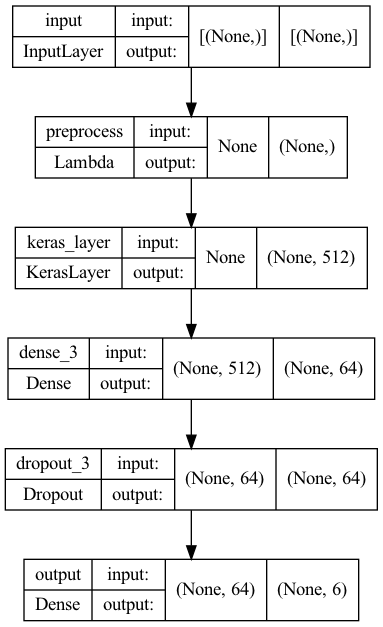

In [28]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

### Train the model

In [29]:
epochs = 5

In [30]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="auto", patience=3, verbose=1
        ),
    ],
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/5


2022-05-02 14:18:25.347239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - ETA: 0s - loss: 1.3860 - sparse_categorical_accuracy: 0.6111

2022-05-02 14:18:33.260797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 12s 108ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.8841 - val_sparse_categorical_accuracy: 0.8400
Epoch 2/5
85/85 [==============================] - 10s 123ms/step - loss: 0.7204 - sparse_categorical_accuracy: 0.8200 - val_loss: 0.5271 - val_sparse_categorical_accuracy: 0.8600
Epoch 3/5
85/85 [==============================] - 11s 123ms/step - loss: 0.5385 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.4472 - val_sparse_categorical_accuracy: 0.8533
Epoch 4/5
85/85 [==============================] - 9s 110ms/step - loss: 0.4729 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.4208 - val_sparse_categorical_accuracy: 0.8650
Epoch 5/5
85/85 [==============================] - 10s 119ms/step - loss: 0.4366 - sparse_categorical_accuracy: 0.8602 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8700


### Plot training curves

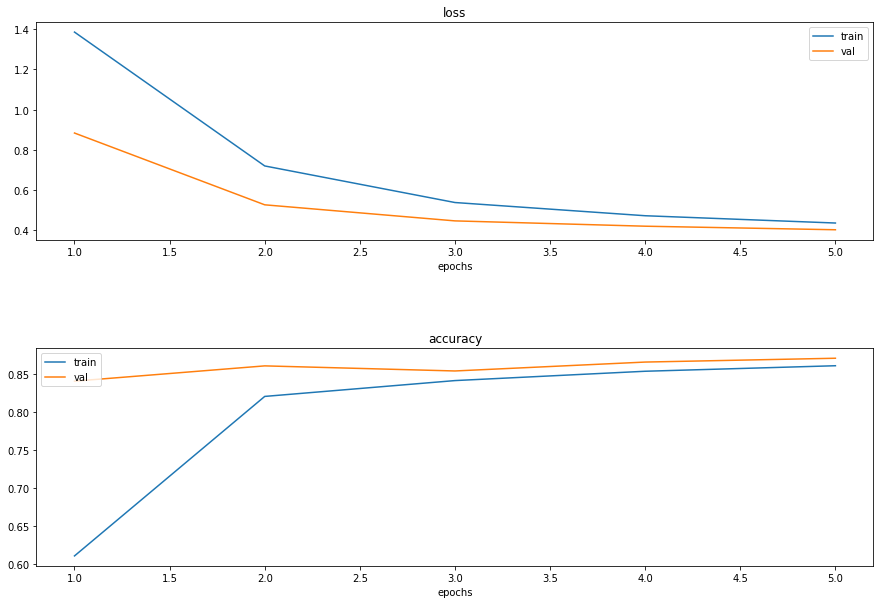

In [31]:
fig = plt.figure(figsize=(15, 10))

epochs = np.arange(1, len(history.history["loss"]) + 1, 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="val")
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, history.history["sparse_categorical_accuracy"], label="train")
plt.plot(epochs, history.history["val_sparse_categorical_accuracy"], label="val")
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend(loc="upper left")

fig.subplots_adjust(hspace=0.5)
fig.savefig("training_history.png", dpi=300)
plt.show()

### Sample evaluation

In [32]:
n = 50
index_evaluation = np.random.choice(X_val.shape[0], n, replace=False)

In [33]:
loss, acc = model.evaluate(X_val[index_evaluation], y_val[index_evaluation], verbose=2)
print("End to end model on evaluation dataset, accuracy: {:5.2f}%".format(100 * acc))

2/2 - 1s - loss: 0.3137 - sparse_categorical_accuracy: 0.9200 - 931ms/epoch - 466ms/step
End to end model on evaluation dataset, accuracy: 92.00%


In [34]:
test_sentences = ["software engineer", "data scientist", "chef"]

In [35]:
preds = model.predict(test_sentences)
labels = class_names[np.argmax(preds, axis=1)]
probs = np.amax(preds, axis=1)

2022-05-02 14:19:17.338883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
for test_sentence, prob, label in zip(test_sentences, probs, labels):
    print(test_sentence, prob, label)

software engineer 0.9858644 IT
data scientist 0.8905193 IT
chef 0.9983189 Food


### Save the model

Now that we have the final model, we can save it on disk and reload it when we need to perform further analysis or make predictions.


In [37]:
model_file_name = "sample_model"

In [38]:
tf.saved_model.save(
    model,
    os.path.join(data_path, model_file_name),
)

2022-05-02 14:19:19.929053: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-05-02 14:19:25.234498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/silvio/Documents/classico/data/sample_model/assets


INFO:tensorflow:Assets written to: /Users/silvio/Documents/classico/data/sample_model/assets


## Load model from disk

In [39]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.saved_model.load(os.path.join(data_path, model_file_name))

2022-05-02 14:19:37.297600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
test_sentences = ["software engineer", "data scientist", "chef"]

In [41]:
preds = model(tf.constant(test_sentences, dtype=tf.string))
labels = class_names[np.argmax(preds, axis=1)]
probs = np.amax(preds, axis=1)

2022-05-02 14:19:37.522014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
for test_sentence, prob, label in zip(test_sentences, probs, labels):
    print(test_sentence, prob, label)

software engineer 0.9858644 IT
data scientist 0.8905193 IT
chef 0.9983189 Food


## Evaluation

In order to understand if the model is good, the best way is to test its performances on datasets that it has never seen. For this reason, we have created different datasets, each for a specific language, where there are mixed titles in terms of data cleanliness and category.

We have a model trained and capable of predicting titles for these languages: Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish and Russian.
 
At `data/sample_evaluation.csv` there is a sample of our multi-language evaluation dataset to test the model

#### Evaluating datasets with top-n accuracy

https://www.quora.com/How-do-I-understand-Top-N-accuracy-in-machine-learning-in-a-simple-way

In [43]:
def top_n_accuracy(titles, categories, class_names, model, n=3):
    acc = 0
    preds = model(titles).numpy()
    top_n_idxs = np.argpartition(preds, kth=n, axis=1)[:, -n:]
    preds = np.take_along_axis(preds, top_n_idxs, axis=-1)
    top_n = np.take_along_axis(top_n_idxs, np.argsort(-preds), axis=-1)
    top_n_labels = class_names[top_n]
    for title, category, top_labels in zip(titles, categories, top_n_labels):
        if category in top_labels:
            acc += 1
    return int(round(acc / len(titles), 2) * 100)

In [44]:
langs = LANGS

In [45]:
eval_map = {lang: {} for lang in langs}

In [46]:
eval_df = pd.read_csv(os.path.join(data_path, EVAL_FILE_NAME))

In [47]:
eval_df.category.unique()

array(['Accounting', 'Education', 'Finance', 'Food', 'IT', 'Medical'],
      dtype=object)

In [48]:
eval_df = pd.read_csv(os.path.join(data_path, EVAL_FILE_NAME))
for n in [1, 3, 5]:
    for lang in langs:
        temp_eval_df = eval_df[eval_df["language"] == lang].copy()
        eval_map[lang][f"accuracy@{n}"] = top_n_accuracy(
            temp_eval_df["title"].values,
            temp_eval_df["category"].values,
            class_names,
            model,
            n=n,
        )
        print(lang, n, eval_map[lang][f"accuracy@{n}"])

2022-05-02 14:19:38.461365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


de 1 31


2022-05-02 14:19:39.377364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


pt 1 20


2022-05-02 14:19:40.345048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


en 1 38
it 1 30
de 3 100
pt 3 100
en 3 100
it 3 100
de 5 100
pt 5 100
en 5 100
it 5 100


### Create evaluation recap dataframe and save it to a csv

In [49]:
complete_acc_df = pd.DataFrame(eval_map).T

In [50]:
complete_acc_df["lang"] = complete_acc_df.index

In [51]:
complete_acc_df

,accuracy@1,accuracy@3,accuracy@5,lang
de,31,100,100,de
pt,20,100,100,pt
en,38,100,100,en
it,30,100,100,it


In [52]:
complete_acc_df.to_csv(os.path.join(data_path, "sample_eval_map_top_n_accuracy.csv"))